In [2]:
pip install torch torchvision torchaudio


In [3]:
pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00


Task0: Apply GCN, GAT, and GraphSage algorithms to Cora dataset in one program

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv, SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [8]:
# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7


Done!


In [9]:
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GAT, self).__init__()
        self.gat1 = GATv2Conv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATv2Conv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define the GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [10]:
# Training and testing functions
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

# Initialize models, optimizers, and loss function
models = {
    'GCN': GCN(dataset.num_node_features, 16, dataset.num_classes),
    'GAT': GAT(dataset.num_node_features, 8, dataset.num_classes),
    'GraphSAGE': GraphSAGE(dataset.num_node_features, 16, dataset.num_classes)
}
optimizers = {name: torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) for name, model in models.items()}
criterion = torch.nn.CrossEntropyLoss()

# Train and test each model
for name, model in models.items():
    print(f'\nTraining {name} model...')
    for epoch in range(200):
        loss = train(model, data, optimizers[name], criterion)
        if epoch % 10 == 0:
            acc = test(model, data)
            print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')
    print(f'{name} training complete!')


Training GCN model...
Epoch 0, Loss: 1.9495, Test Accuracy: 0.4870
Epoch 10, Loss: 0.5402, Test Accuracy: 0.7780
Epoch 20, Loss: 0.0884, Test Accuracy: 0.7900
Epoch 30, Loss: 0.0238, Test Accuracy: 0.7860
Epoch 40, Loss: 0.0133, Test Accuracy: 0.7910
Epoch 50, Loss: 0.0124, Test Accuracy: 0.7930
Epoch 60, Loss: 0.0140, Test Accuracy: 0.7960
Epoch 70, Loss: 0.0158, Test Accuracy: 0.7970
Epoch 80, Loss: 0.0165, Test Accuracy: 0.7990
Epoch 90, Loss: 0.0162, Test Accuracy: 0.8040
Epoch 100, Loss: 0.0154, Test Accuracy: 0.8060
Epoch 110, Loss: 0.0145, Test Accuracy: 0.8030
Epoch 120, Loss: 0.0138, Test Accuracy: 0.8030
Epoch 130, Loss: 0.0131, Test Accuracy: 0.8020
Epoch 140, Loss: 0.0125, Test Accuracy: 0.8020
Epoch 150, Loss: 0.0120, Test Accuracy: 0.8030
Epoch 160, Loss: 0.0116, Test Accuracy: 0.8030
Epoch 170, Loss: 0.0112, Test Accuracy: 0.8030
Epoch 180, Loss: 0.0108, Test Accuracy: 0.8050
Epoch 190, Loss: 0.0105, Test Accuracy: 0.8060
GCN training complete!

Training GAT model...
Ep

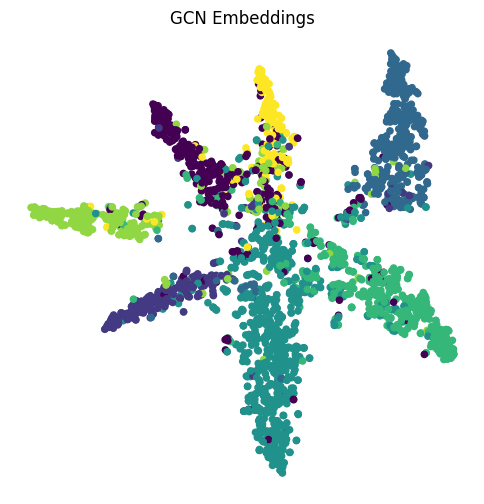

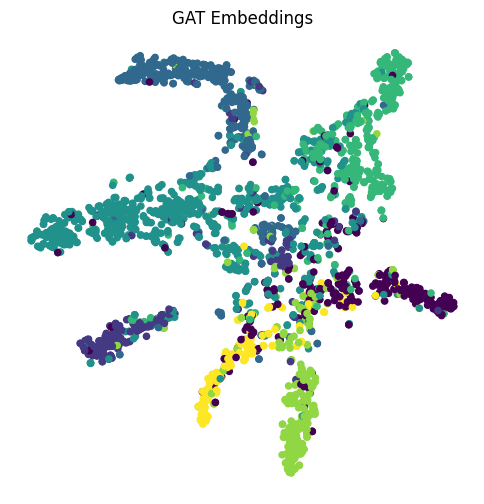

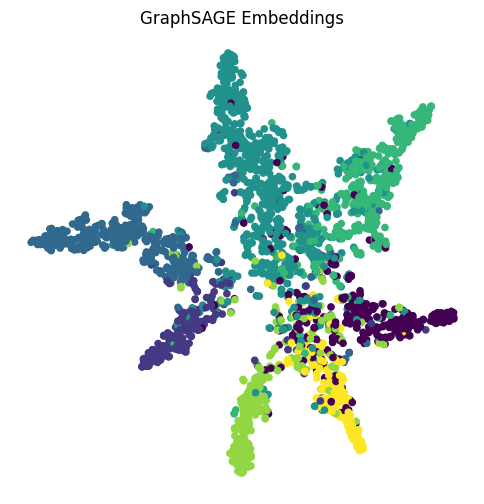

In [11]:
# Visualize embeddings
def visualize(model, data, title):
    model.eval()
    h = model(data.x, data.edge_index)
    tsne = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(h.detach())
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.scatter(tsne[:, 0], tsne[:, 1], s=20, c=data.y)
    plt.title(title)
    plt.show()

for name, model in models.items():
    visualize(model, data, f'{name} Embeddings')

Task 1.1	Effect of Depth on Expressiveness

In [12]:
import numpy as np

# Initialize node features
x = np.array([1, 1, 1, 1, 1])

# Adjacency matrix
A = np.array([
    [0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0],
    [1, 1, 0, 1, 1],
    [0, 1, 1, 0, 1],
    [0, 0, 1, 1, 0]
])

# Initialize node embeddings
h = x.copy()

# Number of message passing layers
num_layers = 0

# Record embeddings at each layer
embeddings = [h.copy()]

# Message passing process
while True:
    num_layers += 1
    h_new = A.dot(h)
    embeddings.append(h_new.copy())

    # Check if embeddings are different
    if np.any(h_new != h):
        break

    h = h_new

print(f'{num_layers} layers of message passing are needed to distinguish the nodes.')
print('Embeddings at each layer:')
for i, emb in enumerate(embeddings):
    print(f'Layer {i}: {emb}')


1 layers of message passing are needed to distinguish the nodes.
Embeddings at each layer:
Layer 0: [1 1 1 1 1]
Layer 1: [2 3 4 3 2]


Task 1.3	Relation to Random Walk (i)

In [13]:
import numpy as np

# Adjacency matrix
A = np.array([
    [0, 1, 1, 0],
    [1, 0, 1, 1],
    [1, 1, 0, 1],
    [0, 1, 1, 0]
])

# Degree matrix
D = np.diag(A.sum(axis=1))

# Random walk transition matrix
M = np.linalg.inv(D).dot(A)

# Initial distribution
r = np.array([0, 0, 1, 0])

# Perform random walk
r_new = M.dot(r)

print("Random walk transition matrix M:")
print(M)

print("\nNew distribution after random walk:")
print(r_new)

# Find the limiting distribution
eigvals, eigvecs = np.linalg.eig(M.T)
limiting_dist = eigvecs[:, np.isclose(eigvals, 1)]
limiting_dist = limiting_dist / limiting_dist.sum()

print("\nLimiting distribution r:")
print(limiting_dist.real.round(3))


Random walk transition matrix M:
[[0.         0.5        0.5        0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.         0.5        0.5        0.        ]]

New distribution after random walk:
[0.5        0.33333333 0.         0.5       ]

Limiting distribution r:
[[0.2]
 [0.3]
 [0.3]
 [0.2]]


Task 1.4	Relation to Random Walk (ii)

In [14]:
import numpy as np

# Adjacency matrix
A = np.array([
    [0, 1, 1, 0],
    [1, 0, 1, 1],
    [1, 1, 0, 1],
    [0, 1, 1, 0]
])

# Degree matrix
D = np.diag(A.sum(axis=1))

# Random walk transition matrix
M = np.linalg.inv(D).dot(A)

print("Random walk transition matrix M:")
print(M)


Random walk transition matrix M:
[[0.         0.5        0.5        0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.         0.5        0.5        0.        ]]


Task 1.6	Learning BFS with GNN

In [15]:
import numpy as np

# Adjacency matrix
A = np.array([
    [0, 1, 1, 0],
    [1, 0, 1, 1],
    [1, 1, 0, 1],
    [0, 1, 1, 0]
])

# Degree matrix
D = np.diag(A.sum(axis=1))

# Normalized adjacency matrix
D_inv = np.linalg.inv(D)
A_norm = D_inv.dot(A)

# Initialize node features
h = np.array([1, 1, 1, 1])

# Number of layers
num_layers = 100

# Record embeddings at each layer
embeddings = [h.copy()]

# Message passing process
for _ in range(num_layers):
    h = A_norm.dot(h)
    embeddings.append(h.copy())

print("Embeddings at each layer:")
for i, emb in enumerate(embeddings):
    print(f'Layer {i}: {emb}')

# Check if embeddings converge
converged = np.allclose(embeddings[-1], embeddings[-2])
print(f'\nDo embeddings converge? {converged}')


Embeddings at each layer:
Layer 0: [1 1 1 1]
Layer 1: [1. 1. 1. 1.]
Layer 2: [1. 1. 1. 1.]
Layer 3: [1. 1. 1. 1.]
Layer 4: [1. 1. 1. 1.]
Layer 5: [1. 1. 1. 1.]
Layer 6: [1. 1. 1. 1.]
Layer 7: [1. 1. 1. 1.]
Layer 8: [1. 1. 1. 1.]
Layer 9: [1. 1. 1. 1.]
Layer 10: [1. 1. 1. 1.]
Layer 11: [1. 1. 1. 1.]
Layer 12: [1. 1. 1. 1.]
Layer 13: [1. 1. 1. 1.]
Layer 14: [1. 1. 1. 1.]
Layer 15: [1. 1. 1. 1.]
Layer 16: [1. 1. 1. 1.]
Layer 17: [1. 1. 1. 1.]
Layer 18: [1. 1. 1. 1.]
Layer 19: [1. 1. 1. 1.]
Layer 20: [1. 1. 1. 1.]
Layer 21: [1. 1. 1. 1.]
Layer 22: [1. 1. 1. 1.]
Layer 23: [1. 1. 1. 1.]
Layer 24: [1. 1. 1. 1.]
Layer 25: [1. 1. 1. 1.]
Layer 26: [1. 1. 1. 1.]
Layer 27: [1. 1. 1. 1.]
Layer 28: [1. 1. 1. 1.]
Layer 29: [1. 1. 1. 1.]
Layer 30: [1. 1. 1. 1.]
Layer 31: [1. 1. 1. 1.]
Layer 32: [1. 1. 1. 1.]
Layer 33: [1. 1. 1. 1.]
Layer 34: [1. 1. 1. 1.]
Layer 35: [1. 1. 1. 1.]
Layer 36: [1. 1. 1. 1.]
Layer 37: [1. 1. 1. 1.]
Layer 38: [1. 1. 1. 1.]
Layer 39: [1. 1. 1. 1.]
Layer 40: [1. 1. 1. 1.]
Laye